# Project 3 - Web APIs & Classification 

## Scenario 

Seeking Alpha site is trying to understand the American consumer's interests in investing and to find the latest buzz words to provide more targeted portfolio offers to them. However, they realized that consumers/users to their sites have mixed interested in pure investment-related posts to anything and everything related to personal finance. This makes it hard for them to identify new customer bases of which they can offer their services too. Due to this problem, they have hired ML company to help them to address this issue.  

Upon taking up this project, ML company have assigned me, a junior data analyst, to help Seeking Alpha to solve this problem.

## Problem Statement  

- Help-Seeking Alpha to build a classification model that help to classify their users' posts based on the words they use and where possible, help to identify consumer's lifestyle habits eg. Buzz words, the time where users are most active in generating posts related to investment.


- The model must be simple enough for non-technical executives to understand and must have at least an 80% success rate of correctly classifying the posts.  
    - The client, Seeking Alpha, understand that in the eyes of consumers, personal finance and investing are closely related and they accept and tolerate some misclassification errors - posts that are wrongly tagged as either personal finance or investing.

## Executive Summary  

Seeking Alpha is looking for a tool/model which can help them to accurately (~80%) identify users, based on their posts, to market to them their financial (investment) products. This marketing campaign is targeted to American netizen only and hence a suitable social news aggregator website, Reddit, is used to gather data. 2 subreddits - Investing and personal finance was chosen to train the model for the following reasons:  

1. Topics are similar; this can be a test to see if the model is robust enough to identify investing posts correctly against the contrasting topic - personal finance


2. Reduced loss - There is a minimum loss to the client if they target their financial products to the wrong groups, personal finance given the similar concerns the users might be facing; they may even convert them as buyers. This may not be the case if the contrasting topic is eg. baking. Users from that groups might complain against them for spam marketing.

**Key Observations**  
- Although selection criteria is that text-based posts where posts are longer than 255 characters are used. There is a sizable number of posts gathered suggesting that there are many users who are concerns about investing and/or personal finance - good business opportunity.


- Users are generally more active from Monday to Thursday, from 9 pm to midnight. This information may help the client to strategize their marketing efforts to ensure maximum reach.


- 2 text-processing techniques are used
    - Counter Vectorizer which simply ranks the importance of words based on the occurrence frequency
    - TF-IDF is a score that tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power.


- 2 type of model are chosen: 
    - logistic regression classifier
    - Naive Bayes Model are trained & test.  


All four models' performance exceeds the minimum accuracy of 80% agreed with clients. TF-IDF Text processing technique and Naive Bayes Modeling were recommended based on business concerns.

## Web Scraping
The web scraping portion of the notebook can be found here: [P003 Web Scraping](P003_Web&#32;Scraping.ipynb)

## Import Library

In [1]:
# Optional setting to setup Jupyter
from IPython.display import display, HTML
display(HTML(data='''
<style>
div#notebook-container    { width: 80%; }
div#menubar-container     { width: 80%; }
div#maintoolbar-container { width: 80%; }
</style>
'''))

In [2]:
# Import Library
import pandas as pd
import numpy as np
import regex as re
import datetime 


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

## nltk to lem & stem 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

# Import packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import package
from wordcloud import WordCloud, STOPWORDS

# Predictive Model
from sklearn.naive_bayes import MultinomialNB

# Confusion Matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_auc_score

# Additional Setting
pd.set_option('display.max_columns', 200)

### User Defined Functions

In [3]:
# Create User-Defined Functions
def rex(text):
    '''
    Perform Regular Expression cleaning on text

    Parameters
    ----------
    text (str): text

    Returns:
    ----------
    func(text): cleaned text
    '''
        
     # Replace \n \r as whitespace
    text = re.sub(r'\\n|\\r|\n|\r', ' ',text)
    
    #Remove all hyperlinks
    text = re.sub(r'http\S+',' ',text)
    
    # Remove all 'call back to subreddit'
    text = re.sub(r'r/investing|r/personalfinance', '',text)
    
    # Keep lettters only
    text = re.sub(r'[^a-zA-Z]',' ', text)
    
    #remove all whitespaces and join words again with 1 whitespace and lower all text
    text = ' '.join(text.split()).lower()   
    
    return text

In [4]:
# Create User-Defined Functions
def text_clean(text,mode):
    '''
    Perform tokenizing of text and stem or lem token by mode
 
    Parameters
    ----------
    text (str): Chunks of words to be tokenized
    mode (str): Either stemming or lemming token
 
    Returns:
    ----------
    return tokenized word
    '''
    ls = []
    # set-up tokenizer
    tokenizer = RegexpTokenizer('\s+', gaps=True)
    text = tokenizer.tokenize(text)
    
     # Remove Stopwords
    stops = set(stopwords.words('english'))
    text = [w for w in text if w not in stops]   
    
    if mode == 'lem':        
        # Lemmatizer word
        lemmatizer = WordNetLemmatizer()
        #lemmatizer.lemmatize(text)
        tokens_lem = [lemmatizer.lemmatize(i) for i in text]
        lem_text = ' '.join(tokens_lem)
        #list(zip(text, tokens_lem))

        # Print only those lemmatized tokens that are different.
    #     for i in range(len(text)):
    #         if text[i] != tokens_lem[i]:
    #             ls.append([text[i], tokens_lem[i]])
        return lem_text
    
    elif mode == 'stem':
        # Stem word
        p_stemmer = PorterStemmer()
        # Stem tokens.
        tokens_stem = [p_stemmer.stem(i) for i in text]
        stem_text = ' '.join(tokens_stem)
        return stem_text

In [5]:
# Create User-Defined Functions
def plot_cloud(wordcloud, fs_tuple):
    '''
    Create a wordcloud based on a string of text given
 
    Parameters
    ----------
    wordcloud (str): a string of text
    fs_tuple  (tup): (width, height) to define the size of the canvas in inches
 
    Returns:
    ----------
    None
    '''
    # Set figure size
    plt.figure(figsize=fs_tuple, facecolor='white')
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    
    return None

In [6]:
# Create User-Defined Functions
def c_matrix(y_true, y_preds, fs_tuple, title):
    '''
    Create a confusion matrix plot
 
    Parameters
    ----------
    y_true   (arr): Actual
    y_preds  (arr): Model Preds
    fs_tuple (tup): (width, height) to define the size of the canvas in inches
    title    (str): title of plot

    Returns:
    ----------
    None
    '''
    
    # Setting up variables to pull from confusion matrix
    cf_matrix = confusion_matrix(y_true, y_preds)
    tn, fp, fn, tp = cf_matrix.ravel()
    
    ## Setting label_name
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = [tn, fp, fn, tp]
    group_pcts = ['{0:.2%}'.format(i) for i in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    # Zipping varaibles together & transform into array
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_counts, group_pcts, group_names)]
    labels = np.asarray(labels).reshape(2,2)
    
    # Setting Stats Summary
    acc = (tp + tn) / np.sum(cf_matrix)
    mis = 1 - acc
    sen = tp/(tp + fn)
    spe = tn/(tn + fp)
    pre = tp/ (tp + fp)
    pvl = (fn + tp) / np.sum(cf_matrix)
    
    print(f'Accuracy: {acc: >14.2f}')
    print(f'Misclassification: {mis: .2f}')
    print(f'Sensitivity: {sen: >11.2f}')
    print(f'Specificity: {spe: >11.2f}')
    print(f'Precision: {pre: >13.2f}')
    print(f'Prevalence: {pvl: >13.2f}')
    
    stat_text = f"\n\nAccuracy: {acc: >17.2f} \nMisclassification: {mis: .2f}\nSensitivity: {sen: >14.2f}\nSpecificity: {spe: >14.2f}\nPrecision: {pre: >16.2f}\nPrevalence: {pvl: >13.2f}"
    
    # plotting of confusion matrix
    plt.figure(figsize=fs_tuple, facecolor='white')
    sns.heatmap(cf_matrix, annot=labels, fmt='', annot_kws={"size": 20}, cmap='Blues')
    plt.ylabel('True', fontsize=20)
    plt.yticks((0.5,1.5),('Personal Finance', 'Investing'), rotation=0, fontsize=15)
    plt.xlabel('Pred' + stat_text, fontsize=20)
    plt.xticks((0.5,1.5),('Personal Finance', 'Investing'), fontsize=15)
    plt.title('Confusion Matrix - ' + title , fontsize= 25)
    
    return None

In [7]:
# Create User-Defined Functions
def roc(dataframe, y_true, y_pred_probas, fs_tuple, txt_xpos, txt_ypos, title):
    '''
    Plot ROC curve
 
    Parameters
    ----------
    dataframe       (df):  Dataframe
    y_true          (arr): Actual
    y_preds_probas  (arr): Model Preds
    fs_tuple        (tup): (width, height) to define the size of the canvas in inches
    txt_xpos        (int): x position of label
    txt_ypos        (int): y position of label
    title           (str): title of plot
 
    Returns:
    ----------
    None
    '''
    # Create threshold values.
    thresholds = np.linspace(0, 1, 200)

    # Define function to calculate sensitivity. (True positive rate.)
    def TPR(df, true_col, pred_prob_col, threshold):
        true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
        false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
        return true_positive / (true_positive + false_negative)


    # Define function to calculate 1 - specificity. (False positive rate.)
    def FPR(df, true_col, pred_prob_col, threshold):
        true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
        false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
        return 1 - (true_negative / (true_negative + false_positive))

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(dataframe, y_true, y_pred_probas, prob) for prob in thresholds]
    fpr_values = [FPR(dataframe, y_true, y_pred_probas, prob) for prob in thresholds]

    # Create figure.
    plt.figure(figsize =fs_tuple, facecolor='white')    
    
    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')
    
    # ROC Score
    scoring = roc_auc_score(dataframe[y_true], dataframe[y_pred_probas])
    score_label = f'AUC Score: {scoring: .2f} out of 1'

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title('Receiver Operating Characteristic Curve - ' + title, fontsize=22)
    plt.ylabel('Sensitivity \n (True Positive Rate)', fontsize=18)
    plt.xlabel('1 - Specificity \n (False Positive Rate)', fontsize=18)
    
    # Create legend.
    plt.legend(fontsize=16);
    
    # Text
    plt.text(txt_xpos, txt_ypos,score_label, fontsize=20)
    
    return None

In [8]:
# Create User-Defined Functions
def error_type(y_true, y_pred):
    '''
    return the error type/label in a confusion matrix
 
    Parameters
    ----------
    y_true   (arr): Actual
    y_preds  (arr): Model Preds
 
    Returns:
    ----------
    return TP, FP, FN, TN
    '''
    # y_true = 1 and y_pred = 1
    if y_true and y_pred:
        return 'TP'
    
    # y_true = 0 and y_pred = 1
    elif not y_true and y_pred:
        return 'FP'
    
    # y_true = 1 and y_pred = 0
    elif y_true and not y_pred:
        return 'FN'
    
    # y_true = 0 and y_pred = 0
    else:
        return 'TN'

## Extraction & Transforming Users' Posts

### Import data

In [9]:
df = pd.read_csv('datasets/combined.csv')
df.head(4)

,no_follow,saved,all_awardings,top_awarded_type,link_flair_background_color,author_premium,visited,link_flair_type,can_gild,subreddit,subreddit_id,edited,is_reddit_media_domain,parent_whitelist_status,mod_note,approved_by,hidden,link_flair_richtext,can_mod_post,id,author,is_original_content,subreddit_type,content_categories,locked,author_fullname,title,hide_score,gildings,view_count,author_cakeday,likes,url,mod_reports,author_flair_text_color,gilded,banned_at_utc,is_self,author_flair_template_id,thumbnail,suggested_sort,media_only,banned_by,is_crosspostable,discussion_type,author_flair_richtext,num_reports,num_crossposts,is_meta,score,upvote_ratio,author_flair_css_class,mod_reason_by,report_reasons,stickied,subreddit_subscribers,quarantine,whitelist_status,created_utc,author_patreon_flair,media_embed,num_comments,user_reports,total_awards_received,secure_media,pinned,archived,treatment_tags,pwls,permalink,ups,distinguished,mod_reason_title,send_replies,author_flair_background_color,removal_reason,wls,domain,author_flair_text,removed_by_category,category,clicked,link_flair_text,approved_at_utc,secure_media_embed,over_18,removed_by,is_robot_indexable,name,link_flair_text_color,selftext,author_flair_type,contest_mode,link_flair_css_class,allow_live_comments,created,media,downs,is_video,selftext_html,subreddit_name_prefixed,awarders,spoiler
0,False,False,[],NaN,NaN,False,False,text,False,investing,t5_2qhhq,False,False,all_ads,NaN,NaN,False,[],False,jh0aqu,rexmakesbeats,False,public,NaN,False,t2_lj3n9,Tesla Weekly Analysis - Week ending 10/24/2020,True,{},NaN,NaN,NaN,https://www.reddit.com/r/investing/comments/jh...,[],NaN,0,NaN,True,NaN,NaN,NaN,False,NaN,False,NaN,[],NaN,0,False,1,1.0,NaN,NaN,NaN,False,1185618,False,all_ads,1.603503e+09,False,{},1,[],0,NaN,False,False,[],6,/r/investing/comments/jh0aqu/tesla_weekly_anal...,1,NaN,NaN,True,NaN,NaN,6,self.investing,NaN,NaN,NaN,False,NaN,NaN,{},False,NaN,True,t3_jh0aqu,dark,Technical analysis on Tesla for the week. We ...,text,False,NaN,False,1.603532e+09,NaN,0,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",r/investing,[],False
1,False,False,[],NaN,NaN,False,False,text,False,investing,t5_2qhhq,False,False,all_ads,NaN,NaN,False,[],False,jh0a9u,jdybka,False,public,NaN,False,t2_53g7qwfc,Book review: Investing In Biotech,True,{},NaN,NaN,NaN,https://www.reddit.com/r/investing/comments/jh...,[],NaN,0,NaN,True,NaN,NaN,NaN,False,NaN,False,NaN,[],NaN,0,False,1,1.0,NaN,NaN,NaN,False,1185618,False,all_ads,1.603503e+09,False,{},1,[],0,NaN,False,False,[],6,/r/investing/comments/jh0a9u/book_review_inves...,1,NaN,NaN,True,NaN,NaN,6,self.investing,NaN,NaN,NaN,False,NaN,NaN,{},False,NaN,True,t3_jh0a9u,dark,"Published 18 years ago, I was hesitant this bo...",text,False,NaN,False,1.603532e+09,NaN,0,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",r/investing,[],False
2,False,False,[],NaN,NaN,False,False,text,False,investing,t5_2qhhq,False,False,all_ads,NaN,NaN,False,[],False,jh08np,louissanchez84,False,public,NaN,False,t2_rv3pk,Need some advice for Porfollios,True,{},NaN,NaN,NaN,https://www.reddit.com/r/investing/comments/jh...,[],NaN,0,NaN,True,NaN,NaN,NaN,False,NaN,False,NaN,[],NaN,0,False,1,1.0,NaN,NaN,NaN,False,1185618,False,all_ads,1.603503e+09,False,{},1,[],0,NaN,False,False,[],6,/r/investing/comments/jh08np/need_some_advice_...,1,NaN,NaN,True,NaN,NaN,6,self.investing,NaN,NaN,NaN,False,NaN,NaN,{},False,NaN,True,t3_jh08np,dark,I'm willing to take some risk on all portfolio...,text,False,NaN,False,1.603532e+09,NaN,0,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",r/investing,[],False
3,False,False,[],NaN,NaN,False,False,text,False,investing,t5_2qhhq,False,False,all_ads,NaN,NaN,False,[],False,jgzoym,ttyler1789,False,public,NaN,False,t2_1e3atzjp,New(?) investing strategy?,True,{},NaN,NaN,NaN,https://www.reddit.com/r/investing/comments/jg...,[],NaN,0,NaN,True,NaN,NaN,NaN,False,NaN,False,NaN,[],NaN,1,False,0,0.4,NaN,NaN,NaN,False,1185618,False,all_ads,1.603501e+09,Fals

### Retain relevant Columns

In [10]:
# Relevant Columns that will help in the classification process
retain_cols = ['subreddit','selftext','author_fullname','title','link_flair_css_class', 'upvote_ratio', 'ups',\
        'score','created_utc']

In [11]:
df = df[retain_cols]

In [12]:
df.head()

,subreddit,selftext,author_fullname,title,link_flair_css_class,upvote_ratio,ups,score,created_utc
0,investing,Technical analysis on Tesla for the week. We ...,t2_lj3n9,Tesla Weekly Analysis - Week ending 10/24/2020,NaN,1.0,1,1,1.603503e+09
1,investing,"Published 18 years ago, I was hesitant this bo...",t2_53g7qwfc,Book review: Investing In Biotech,NaN,1.0,1,1,1.603503e+09
2,investing,I'm willing to take some risk on all portfolio...,t2_rv3pk,Need some advice for Porfollios,NaN,1.0,1,1,1.603503e+09
3,investing,I've posted this on r/wallstreetbets a couple ...,t2_1e3atzjp,New(?) investing strategy?,NaN,0.4,0,0,1.603501e+09
4,investing,I also asked r/stocks but it's probably better...,t2_4uwlv6py,"For those of you that invest in ""big name"" EV ...",NaN,1.0,1,1,1.603499e+09


In [13]:
# Change created_utc into datetime data type
df['created_utc'] = df['created_utc'].map(lambda x: datetime.datetime.fromtimestamp(x,))

In [14]:
df[['created_utc']].head()

,created_utc
0,2020-10-24 09:35:30
1,2020-10-24 09:34:39
2,2020-10-24 09:31:43
3,2020-10-24 08:54:44
4,2020-10-24 08:16:16


In [15]:
# Separate created time into month, weekday and hours
df['month'] = df['created_utc'].dt.month
df['weekday'] = df['created_utc'].dt.weekday
df['hour'] = df['created_utc'].dt.hour

In [16]:
df.head()

,subreddit,selftext,author_fullname,title,link_flair_css_class,upvote_ratio,ups,score,created_utc,month,weekday,hour
0,investing,Technical analysis on Tesla for the week. We ...,t2_lj3n9,Tesla Weekly Analysis - Week ending 10/24/2020,NaN,1.0,1,1,2020-10-24 09:35:30,10,5,9
1,investing,"Published 18 years ago, I was hesitant this bo...",t2_53g7qwfc,Book review: Investing In Biotech,NaN,1.0,1,1,2020-10-24 09:34:39,10,5,9
2,investing,I'm willing to take some risk on all portfolio...,t2_rv3pk,Need some advice for Porfollios,NaN,1.0,1,1,2020-10-24 09:31:43,10,5,9
3,investing,I've posted this on r/wallstreetbets a couple ...,t2_1e3atzjp,New(?) investing strategy?,NaN,0.4,0,0,2020-10-24 08:54:44,10,5,8
4,investing,I also asked r/stocks but it's probably better...,t2_4uwlv6py,"For those of you that invest in ""big name"" EV ...",NaN,1.0,1,1,2020-10-24 08:16:16,10,5,8


### Text Cleaning

In [17]:
df['story']= df['title'] + " - " + df['selftext']

In [18]:
df.loc[1,'story']

"Book review: Investing In Biotech - Published 18 years ago, I was hesitant this book would be outdated. It does show signs of age when David Harper gives specific examples of biotechs. In one case he mentions Nexia Biotechnologies which went bankrupt almost 10 years ago. Although there was a lot of hype around the company's product; using [genetically engineered goats](https://www.cbc.ca/news/canada/ottawa/spider-goats-display-angers-ottawa-professor-1.1137229) to manufacture BioSteel. Sounds revolutionary and high tech, which makes it a good cautionary tale. It's easy to get hyped about the products but that doesn't mean it's economically viable.\n\nThe book did have some timeless advice though. I've made a list of some points to consider when researching a biotech:\n\n1.The goals of each clinical trial:\n\nPreclinical: Animal testing\n\nPhase 1: Is it safe?\n\nPhase 2: Does it work?\n\nPhase 4: Is it safe and does it work for a lot of people?\n\n2.Be wary if the FDA is questioning t

In [19]:
df.loc[1,'story']

"Book review: Investing In Biotech - Published 18 years ago, I was hesitant this book would be outdated. It does show signs of age when David Harper gives specific examples of biotechs. In one case he mentions Nexia Biotechnologies which went bankrupt almost 10 years ago. Although there was a lot of hype around the company's product; using [genetically engineered goats](https://www.cbc.ca/news/canada/ottawa/spider-goats-display-angers-ottawa-professor-1.1137229) to manufacture BioSteel. Sounds revolutionary and high tech, which makes it a good cautionary tale. It's easy to get hyped about the products but that doesn't mean it's economically viable.\n\nThe book did have some timeless advice though. I've made a list of some points to consider when researching a biotech:\n\n1.The goals of each clinical trial:\n\nPreclinical: Animal testing\n\nPhase 1: Is it safe?\n\nPhase 2: Does it work?\n\nPhase 4: Is it safe and does it work for a lot of people?\n\n2.Be wary if the FDA is questioning t

In [20]:
# Perform data cleaning using regular expression
df['rex_clean'] = df['story'].map(lambda x: rex(x))

In [21]:
df.loc[1,'rex_clean']

'book review investing in biotech published years ago i was hesitant this book would be outdated it does show signs of age when david harper gives specific examples of biotechs in one case he mentions nexia biotechnologies which went bankrupt almost years ago although there was a lot of hype around the company s product using genetically engineered goats to manufacture biosteel sounds revolutionary and high tech which makes it a good cautionary tale it s easy to get hyped about the products but that doesn t mean it s economically viable the book did have some timeless advice though i ve made a list of some points to consider when researching a biotech the goals of each clinical trial preclinical animal testing phase is it safe phase does it work phase is it safe and does it work for a lot of people be wary if the fda is questioning the statistics of a trial it s a possible sign the company will have to redo it this is costly and time consuming alliances are key are they partnering with

In [22]:
# Lemmatizing words
df['lem_text'] = df['rex_clean'].map(lambda x: text_clean(x, mode='lem'))

In [23]:
df['lem_text']

0       tesla weekly analysis week ending technical an...
1       book review investing biotech published year a...
2       need advice porfollios willing take risk portf...
3       new investing strategy posted r wallstreetbets...
4       invest big name ev company like tesla nio hedg...
                              ...                        
2986    weekday help victory thread week august need h...
2987    potential employer offered pay le job applicat...
2988    coronavirus megathread update resource discuss...
2989    coronavirus megathread update resource discuss...
2990    coronavirus megathread update resource discuss...
Name: lem_text, Length: 2991, dtype: object

In [24]:
# Stemming words
df['stem_text'] = df['rex_clean'].map(lambda x: text_clean(x, mode='stem'))

In [25]:
df['stem_text']

0       tesla weekli analysi week end technic analysi ...
1       book review invest biotech publish year ago he...
2       need advic porfollio will take risk portfolio ...
3       new invest strategi post r wallstreetbet coupl...
4       invest big name ev compani like tesla nio hedg...
                              ...                        
2986    weekday help victori thread week august need h...
2987    potenti employ offer pay less job applic appli...
2988    coronaviru megathread updat resourc discuss qu...
2989    coronaviru megathread updat resourc discuss qu...
2990    coronaviru megathread updat resourc discuss qu...
Name: stem_text, Length: 2991, dtype: object

### Tagging of subreddit

In [26]:
df['reddit_tag'] = df['subreddit'].map({'investing': 1, 'personalfinance':0})

In [27]:
df['reddit_tag'].value_counts(normalize=True)

0    0.635573
1    0.364427
Name: reddit_tag, dtype: float64

In [28]:
df['story_lem_len'] = df['lem_text'].str.len()

In [29]:
df.shape

(2991, 18)

In [30]:
# Look for story that have at least 255 characters.
df = df[df['story_lem_len']>255]

<span style= "color:magenta">Remarks:</span>  
The tagging is to create a column which can be use as the Y-variable for training the model.  
The next step is to filter posts that have less than 255 characters. The 255 character limit is an arbitrary numbers which I determined based on a quick look at most of the posts. Posts that are below this limits tend to contains little to no information or hyperlinks that redirects users to other sites.

In [31]:
df.shape

(2264, 18)

In [32]:
df.head(2)

,subreddit,selftext,author_fullname,title,link_flair_css_class,upvote_ratio,ups,score,created_utc,month,weekday,hour,story,rex_clean,lem_text,stem_text,reddit_tag,story_lem_len
0,investing,Technical analysis on Tesla for the week. We ...,t2_lj3n9,Tesla Weekly Analysis - Week ending 10/24/2020,NaN,1.0,1,1,2020-10-24 09:35:30,10,5,9,Tesla Weekly Analysis - Week ending 10/24/2020...,tesla weekly analysis week ending technical an...,tesla weekly analysis week ending technical an...,tesla weekli analysi week end technic analysi ...,1,519
1,investing,"Published 18 years ago, I was hesitant this bo...",t2_53g7qwfc,Book review: Investing In Biotech,NaN,1.0,1,1,2020-10-24 09:34:39,10,5,9,Book review: Investing In Biotech - Published ...,book review investing in biotech published yea...,book review investing biotech published year a...,book review invest biotech publish year ago he...,1,1252


### Word Cloud

In [33]:
# Investing
lem_text_total_1 = ' '.join(df['lem_text'][df['reddit_tag']==1])

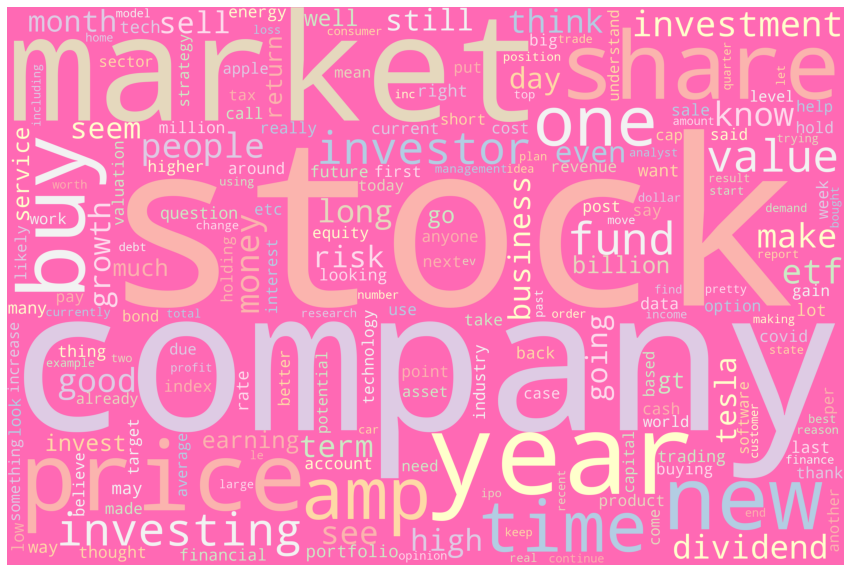

In [34]:
# Generate word cloud of investing subreddit
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='Hotpink', colormap='Pastel1', \
                      collocations=False, stopwords = STOPWORDS).generate(lem_text_total_1)
# Plot
plot_cloud(wordcloud, (15,15))

<span style= "color:magenta">Remarks:</span> A quick look at the word cloud show that most of the posts that are classified as investing have high frequency words relating to investing eg. stock, company, market, share. This give an indication that majority of posts has been posted correctly in the respective subreddits.

In [35]:
# Personal Finance
lem_text_total_0 = ' '.join(df['lem_text'][df['reddit_tag']==0])

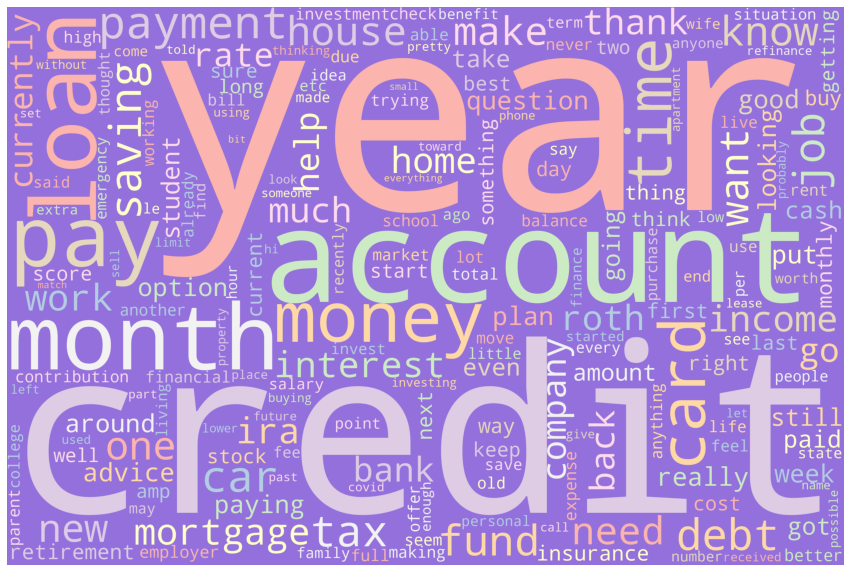

In [36]:
# Generate word cloud of personal Finance subreddit
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='mediumpurple', colormap='Pastel1', \
                      collocations=False, stopwords = STOPWORDS).generate(lem_text_total_0)
# Plot
plot_cloud(wordcloud, (15,15))

<span style= "color:magenta">Remarks:</span>  A quick look at the word cloud show that most of the posts that are classified as investing have high frequency words relating to investing eg. account, credit, loan, income, mortgage. However, there are some words such as year & month that are high in term of frequncy among all the posts. As these words may be relating to terms ~ payment term , they will need to be removed since they will likely appear in both personal finance & investing subreddits.

## Modeling of Lem text

<span style= "color:magenta">Remarks:</span> Both Stemming and Lemmatization both generate the root form of the inflected words. The difference is that stem might not be an actual word whereas, lemma is an actual language word.Stemming follows an algorithm with steps to perform on the words which makes it faster. Whereas, in lemmatization, you used WordNet corpus and a corpus for stop words as well to produce lemma which makes it slower than stemming. Based on this, Lemmatized Text is used for modeling as it retain the characteristic of the posts better than stemming.

In [37]:
X_lem = df['lem_text']
y_lem = df['reddit_tag']

### Baseline Model

In [38]:
y_lem.value_counts()

0    1451
1     813
Name: reddit_tag, dtype: int64

In [39]:
y_lem.value_counts(normalize=True)

0    0.640901
1    0.359099
Name: reddit_tag, dtype: float64

<span style= "color:magenta">Remarks:</span> Looking at the users' posts that I have collected, the count of the posts will be a baseline in which I can evluate against my classification models that I will be created. Looking at the ratio of the based like, it is roughly 65% - 35%, the proportion is not too skewed, best case is 50:50, but  I will be stratifying my train-test-split to ensure that the models are trained properly.

In [40]:
# Split the data into the training and testing sets.
X_lem_train, X_lem_val, y_lem_train, y_lem_val = train_test_split(X_lem,
                                                    y_lem,
                                                    test_size=0.33,
                                                    stratify=y_lem,
                                                    random_state=42)

## Log Regression using CountVectorizer

### Pipeline Creation

In [41]:
# Adding pre-identifed stopwords to CountVector STOPWORDS.
stop_words = text.ENGLISH_STOP_WORDS.union(['year', 'month'])

<span style= "color:magenta">Remarks:</span> From the wordcloud we did identify 'year' & 'month' are words that do not help in the models, these will be added to CountVectorizer's stopwords.  
A new list is created to hold the union of the words.

In [42]:
stop_words = list(stop_words)

In [43]:
# Create pipeline
pipe_log_cv = Pipeline(
[
    ('cvec', CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stop_words )),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
]
)

In [44]:
pipe_log_cv.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(stop_words=['mill', 'your', 'seeming', 'first', 'bill', 'will',
                               'would', 'by', 'perhaps', 'sometime', 'none', 'it',
                               'is', 'ie', 'two', 'five', 'whereby', 'has', 'inc',
                               'also', 'with', 'up', 'de', 'wherever', 'must',
                               'found', 'three', 'from', 'others', 'where', ...])),
  ('lr', LogisticRegression(max_iter=1000))],
 'verbose': False,
 'cvec': CountVectorizer(stop_words=['mill', 'your', 'seeming', 'first', 'bill', 'will',
                             'would', 'by', 'perhaps', 'sometime', 'none', 'it',
                             'is', 'ie', 'two', 'five', 'whereby', 'has', 'inc',
                             'also', 'with', 'up', 'de', 'wherever', 'must',
                             'found', 'three', 'from', 'others', 'where', ...]),
 'lr': LogisticRegression(max_iter=1000),
 'cvec__analyzer': 'word',
 'cvec__

In [45]:
pipe_log_cv_params = {'cvec__ngram_range': [(1,1),(1,2),(1,3),(1,4)],
                   'cvec__max_df': [0.5,0.6,0.7,0.8],
                   'cvec__min_df': [0.1,0.2,0.3],
                   'cvec__max_features': [1000, 2000,3000,4000,5000]               
}

### GridSearch to find the best params

In [46]:
gs = GridSearchCV(pipe_log_cv,pipe_log_cv_params, cv=5)

In [47]:
gs.fit(X_lem_train, y_lem_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['mill',
                                                                    'your',
                                                                    'seeming',
                                                                    'first',
                                                                    'bill',
                                                                    'will',
                                                                    'would',
                                                                    'by',
                                                                    'perhaps',
                                                                    'sometime',
                                                                    'none',
                                                                    'it', 'is',
       

In [48]:
# Find the best params for countvector
gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 1000,
 'cvec__min_df': 0.1,
 'cvec__ngram_range': (1, 1)}

In [49]:
gs.score(X_lem_train, y_lem_train)

0.9102902374670184

In [50]:
gs.score(X_lem_val, y_lem_val)

0.8770053475935828

<span style= "color:magenta">Remarks:</span> Looking at the accuracy score of both the train and the evaluation blocks, there do not seems to have a huge difference. The accuracy only dropped by about 3% using the evaluation set. This is within the acceptable range that we can tolerate.

### Checking the most frequent words in corpus

In [51]:
# Zipping the feature name and coefficients together
ls = zip(gs.best_estimator_.steps[0][1].get_feature_names(), np.exp(gs.best_estimator_.steps[1][1].coef_[0]))
lem_word_log = pd.DataFrame(data=list(ls))
lem_word_log.rename(columns={0: 'word', 1:'coeff'},inplace=True)
lem_word_log.sort_values(by='coeff', ascending=False, inplace=True)

 # filter for only the top 20 keywords
lem_word_log = lem_word_log.head(60)
lem_word_log.head(5)

,word,coeff
22,financial,2.128518
49,market,1.679316
7,better,1.677219
81,think,1.666195
36,investment,1.645230


In [52]:
lem_word_log['word'][lem_word_log['coeff']>1]

22     financial
49        market
7         better
81         think
36    investment
46           low
20           end
34        invest
43          look
64         price
61        people
35     investing
25         going
40          like
4            amp
72           say
74         stock
85           use
13       company
78          term
70          said
29          high
82       thought
8            buy
45           lot
44       looking
86         value
12          come
18           day
11          cash
54           new
32          idea
66          rate
42          long
63         point
Name: word, dtype: object

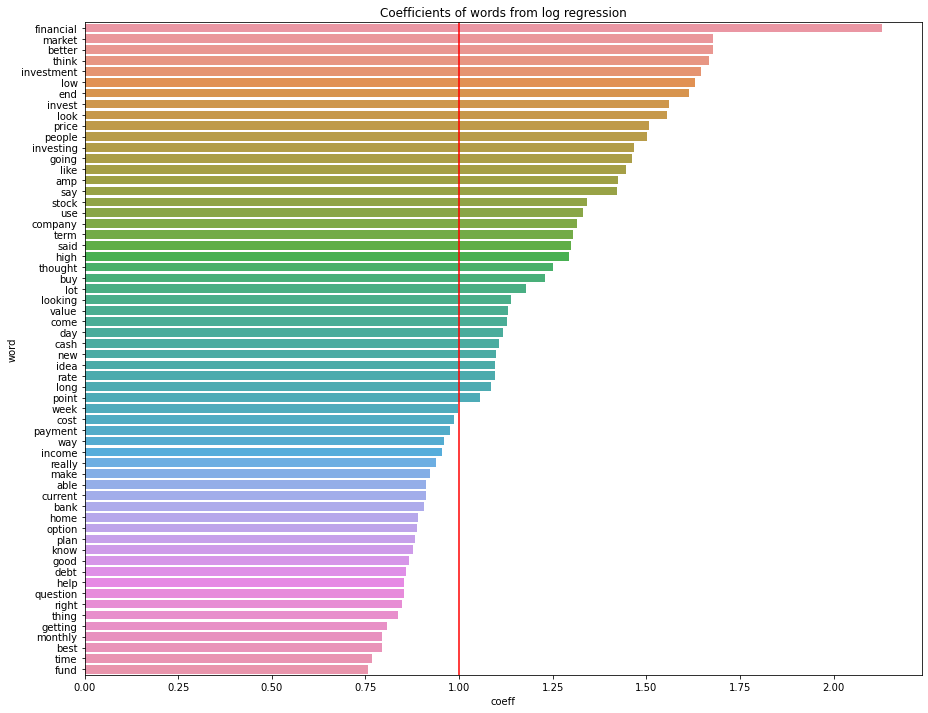

In [53]:
fig, ax = plt.subplots(figsize=(15,12), facecolor='white')
sns.barplot(data=lem_word_log, y='word', x='coeff')
plt.axvline(x=1, color='red')
plt.title('Coefficients of words from log regression');

<span style= "color:magenta">Remarks:</span> Looking at the top 60 words with the highest frequency, there are alot of words which cannot assist to classify the subreddit. As such, these words will be removed from the model. An arbitrage cutoff of 1 ~ words that are of no predictive value with coefficient value of >1 will be removed as they will have bigger impact on the log regression which we want to minimise.

In [54]:
# Create custom Stopwords
custom_stopwords = ['better', 'think', 'end', 'look', 'people', 'going', 'like', 'say', 'use'\
                   'said', 'thought','looking','come', 'day', 'new', 'long', 'point']

# Add custom stopwords to stop_words
stop_words.extend(custom_stopwords)

### Log Reg with Count Vec (Best Params)

In [55]:
# Create pipe2 with best params + using custom stopwords
pipe_log_2 = Pipeline(
[
    ('cvec', CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stop_words,
                             ngram_range=(1, 1),
                             max_df=0.5,
                             min_df=0.1,
                             max_features = 1000)),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
]
)

In [56]:
# Mean Accuracy
cross_val_score(pipe_log_2, X_lem_train, y_lem_train, cv=5).mean() 

0.8759857564703839

In [57]:
# Fit Model
pipe_log_2.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=0.1,
                                 stop_words=['mill', 'your', 'seeming', 'first',
                                             'bill', 'will', 'would', 'by',
                                             'perhaps', 'sometime', 'none',
                                             'it', 'is', 'ie', 'two', 'five',
                                             'whereby', 'has', 'inc', 'also',
                                             'with', 'up', 'de', 'wherever',
                                             'must', 'found', 'three', 'from',
                                             'others', 'where', ...])),
                ('lr', LogisticRegression(max_iter=1000))])

In [58]:
# Train Model accuracy
pipe_log_2.score(X_lem_train, y_lem_train)

0.9089709762532981

In [59]:
# Test accuracy
pipe_log_2.score(X_lem_val, y_lem_val)

0.8770053475935828

<span style= "color:magenta">Remarks:</span> Our model's accuracy for the evaluation dataset has neither improve or deteriorate greatly against the training dataset, suggesting that removing custom stop words is not a necessary process for this dataset.

### Evaluating Log Reg with Count Vec

In [60]:
# Find prediction
pred_log_2 = pipe_log_2.predict(X_lem_val)

# Find Prediction Probability
pred_log_2_proba = [i[1] for i in pipe_log_2.predict_proba(X_lem_val)]

# Create dataframe of y-subset for ROC
pred_log_2_df = pd.DataFrame({'y_true': y_lem_val,
                            'pred_y': pred_log_2,
                        'pred_probs':pred_log_2_proba})

In [61]:
pred_log_2_df.head()

,y_true,pred_y,pred_probs
671,1,1,7.196721e-01
349,1,1,6.677529e-01
1580,0,0,5.329551e-07
1949,0,1,5.505249e-01
2038,0,0,2.805176e-06


#### ROC Curve: Log Reg with Count Vec

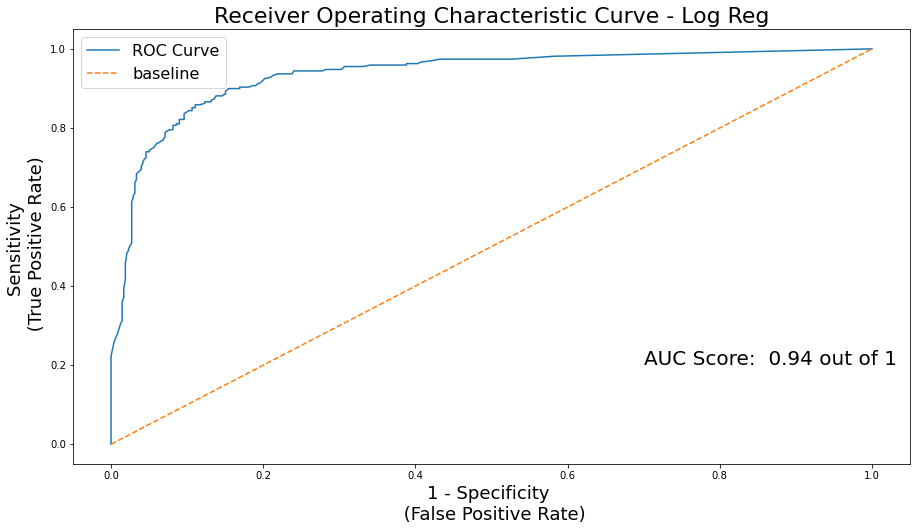

In [62]:
# ROC of y_val
roc(pred_log_2_df, 'y_true', 'pred_probs', (15,8), 0.7,0.2, 'Log Reg')

<span style= "color:magenta">Remarks:</span> Looking at the ROC curve, with a AUC socre of 0.94 which is very close to 1. It give me confident that the model is working well against the evaluation data set. The max score of AUC scorce is 1.

#### Confusion Matrix: Log Reg with Count Vec

In [63]:
# Generate a confusion matrix.
confusion_matrix(y_lem_val,pred_log_2)

array([[427,  52],
       [ 40, 229]], dtype=int64)

Accuracy:           0.88
Misclassification:  0.12
Sensitivity:        0.85
Specificity:        0.89
Precision:          0.81
Prevalence:          0.36


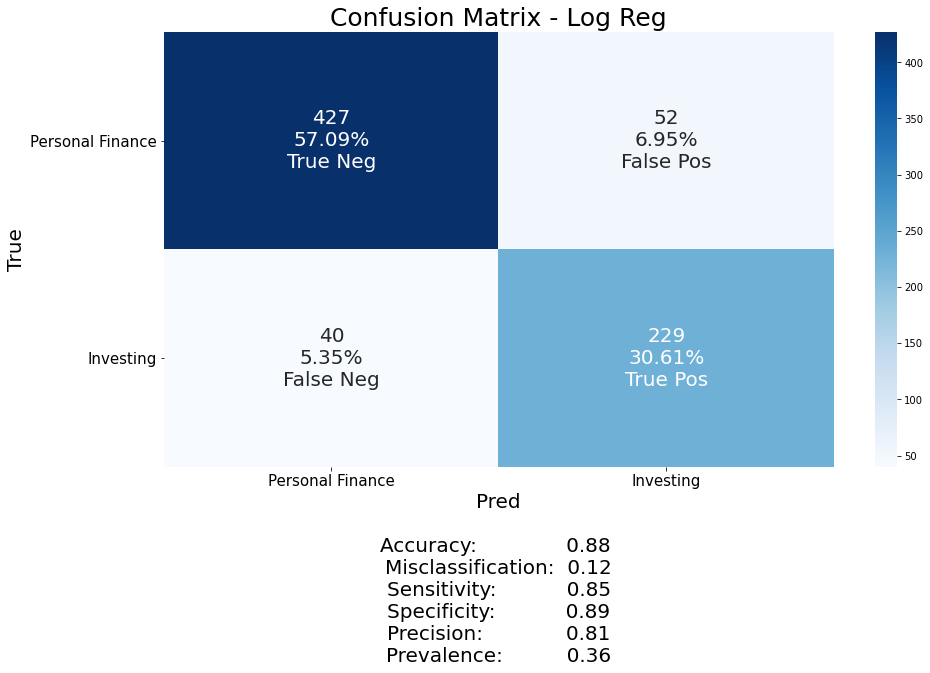

In [64]:
# Print Confusion Matrix Statistic
c_matrix(y_lem_val, pred_log_2, (15,8), 'Log Reg')

In [65]:
# Reform X_val and y_val with prediction
df_val = pd.concat([X_lem_val,pred_log_2_df], axis=1)

# Add in confusion matrix - filter for those that are Type 1 or Type 2 errors
df_val['c_matrix'] = df_val.apply(lambda row: error_type(row['y_true'], row['pred_y']), axis=1)
mask1 = (df_val['c_matrix'] == 'FP') | (df_val['c_matrix'] == 'FN')
df_val[mask1].shape

(92, 5)

<span style= "color:magenta">Remarks:</span> Looking at the confusion matrix, our model is able to class user's comment quite accuracy @ 88%, this is above our agreed thresoldof 80%.  
We do notice there there is about 12% errors in our model (Type I & Type II). Upon Investigation, I realized that most of these errors are resulted from users themselves not able to clearly defined their posts as being personal finance or investing.  
As mentioned in the introduction, this is an expected concern as investing are very closely related to personal finance and users might not be to "class" their posts accordingly. Besides, the errors, especially type II, are not an issues to our client, Seeking Alpha, as it may means unexpected customers.

In [66]:
# Save 
df_val.to_csv('datasets/log_reg_cv_c_matrix_errors.csv')

## Log Regression using TF-IDF

### Pipeline Creation

In [67]:
# Create pipeline
pipe_log_reg_tfidf = Pipeline(
[
    ('cvec', TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stop_words)),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
]
)

In [68]:
pipe_log_reg_tfidf.get_params()

{'memory': None,
 'steps': [('cvec',
   TfidfVectorizer(stop_words=['mill', 'your', 'seeming', 'first', 'bill', 'will',
                               'would', 'by', 'perhaps', 'sometime', 'none', 'it',
                               'is', 'ie', 'two', 'five', 'whereby', 'has', 'inc',
                               'also', 'with', 'up', 'de', 'wherever', 'must',
                               'found', 'three', 'from', 'others', 'where', ...])),
  ('lr', LogisticRegression(max_iter=1000))],
 'verbose': False,
 'cvec': TfidfVectorizer(stop_words=['mill', 'your', 'seeming', 'first', 'bill', 'will',
                             'would', 'by', 'perhaps', 'sometime', 'none', 'it',
                             'is', 'ie', 'two', 'five', 'whereby', 'has', 'inc',
                             'also', 'with', 'up', 'de', 'wherever', 'must',
                             'found', 'three', 'from', 'others', 'where', ...]),
 'lr': LogisticRegression(max_iter=1000),
 'cvec__analyzer': 'word',
 'cvec__

### GridSearch to find the best params

In [69]:
pipe_log_reg_tfidf_params = {'cvec__ngram_range': [(1,1),(1,2),(1,3),(1,4)],
                   'cvec__max_df': [0.5,0.6,0.7,0.8],
                   'cvec__min_df': [0.1,0.2,0.3],
                   'cvec__max_features': [1000, 2000,3000,4000,5000]               
}

In [70]:
gs = GridSearchCV(pipe_log_reg_tfidf,pipe_log_reg_tfidf_params, cv=5)

In [71]:
gs.fit(X_lem_train, y_lem_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words=['mill',
                                                                    'your',
                                                                    'seeming',
                                                                    'first',
                                                                    'bill',
                                                                    'will',
                                                                    'would',
                                                                    'by',
                                                                    'perhaps',
                                                                    'sometime',
                                                                    'none',
                                                                    'it', 'is',
       

In [72]:
# Find the best params for countvector
gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 1000,
 'cvec__min_df': 0.1,
 'cvec__ngram_range': (1, 2)}

In [73]:
gs.score(X_lem_train, y_lem_train)

0.9089709762532981

In [74]:
gs.score(X_lem_val, y_lem_val)

0.8943850267379679

<span style= "color:magenta">Remarks:</span> Looking at the accuracy score of both the train and the evaluation blocks, there do not seems to have a huge difference. The accuracy only dropped by about 1% using the evaluation set. This is within the acceptable range that we can tolerate.

### Checking the most frequent words in corpus

In [75]:
# Zipping the feature name and coefficients together
ls = zip(gs.best_estimator_.steps[0][1].get_feature_names(), np.exp(gs.best_estimator_.steps[1][1].coef_[0]))
lem_word_log = pd.DataFrame(data=list(ls))
lem_word_log.rename(columns={0: 'word', 1:'coeff'},inplace=True)
lem_word_log.sort_values(by='coeff', ascending=False, inplace=True)

 # filter for only the top 20 keywords
lem_word_log = lem_word_log.head(60)
lem_word_log.head(5)

,word,coeff
41,market,12.435667
62,stock,7.934596
11,company,6.338952
53,price,6.061718
32,investment,3.722124


In [76]:
lem_word_log['word'][lem_word_log['coeff']>1]

41        market
62         stock
11       company
53         price
32    investment
31     investing
4            amp
7            buy
72         value
25          high
38           low
71           use
37           lot
66          term
19     financial
59          said
30        invest
28          idea
35          know
74           way
56        really
22          good
39          make
Name: word, dtype: object

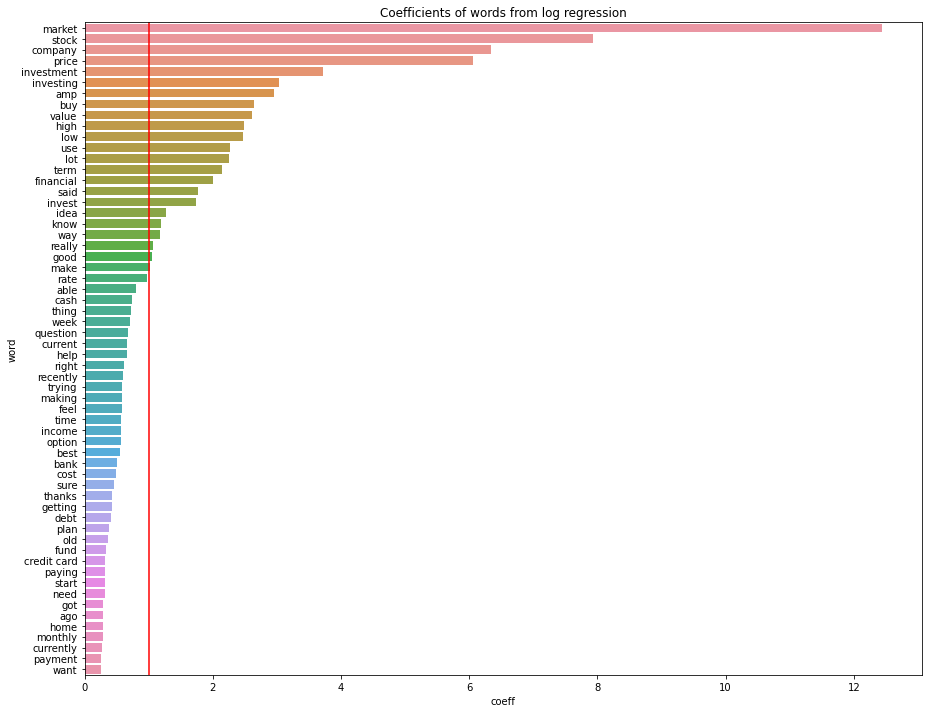

In [77]:
fig, ax = plt.subplots(figsize=(15,12), facecolor='white')
sns.barplot(data=lem_word_log, y='word', x='coeff')
plt.axvline(x=1, color='red')
plt.title('Coefficients of words from log regression');

<span style= "color:magenta">Remarks:</span> Looking at the top 60 words with the highest frequency, although cleaner compared to countvectorizer, there are still some words that do not assists to make the prediction model better. Hence I will be creating a custom list of stopwords. Again, I will be using an arbitrary number of 1. Any words with coefficient less than 1, I will not include them into the stopwords list.

In [78]:
# Create custom Stopwords
custom_stopwords = ['use', 'said', 'idea', 'know', 'way', 'really', 'make']

stop_words.extend(custom_stopwords)

### Log Reg with TF-IDF (Best Params)

In [79]:
# Create pipe2 with best params + using custom stopwords
pipe_log_reg_tfidf_2 = Pipeline(
[
    ('cvec', TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stop_words,
                             ngram_range=(1, 2),
                             max_df=0.5,
                             min_df=0.1,
                             max_features = 1000)),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
]
)

In [80]:
# Mean Accuracy
cross_val_score(pipe_log_reg_tfidf_2, X_lem_train, y_lem_train, cv=5).mean() 

0.8924787215563661

In [81]:
# Fit Model
pipe_log_reg_tfidf_2.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('cvec',
                 TfidfVectorizer(max_df=0.5, max_features=1000, min_df=0.1,
                                 ngram_range=(1, 2),
                                 stop_words=['mill', 'your', 'seeming', 'first',
                                             'bill', 'will', 'would', 'by',
                                             'perhaps', 'sometime', 'none',
                                             'it', 'is', 'ie', 'two', 'five',
                                             'whereby', 'has', 'inc', 'also',
                                             'with', 'up', 'de', 'wherever',
                                             'must', 'found', 'three', 'from',
                                             'others', 'where', ...])),
                ('lr', LogisticRegression(max_iter=1000))])

In [82]:
# Train Model accuracy
pipe_log_reg_tfidf_2.score(X_lem_train, y_lem_train)

0.908311345646438

In [83]:
# Test accuracy
pipe_log_reg_tfidf_2.score(X_lem_val, y_lem_val)

0.8850267379679144

<span style= "color:magenta">Remarks:</span> By removing words using custom stop words, our model accuracy have dropped by 0.2%. Again, there is not much improvement or deteoriation in term of accuracy and may suggest that removing custom stop words is not necessary for this dataset.

### Evaluating Log Reg with TF-IDF

In [84]:
# Find prediction
pred_log_reg_tfidf_2 = pipe_log_reg_tfidf_2.predict(X_lem_val)

# Find Prediction Probability
pred_log_reg_tfidf_2_proba = [i[1] for i in pipe_log_reg_tfidf_2.predict_proba(X_lem_val)]

# Create dataframe of y-subset for ROC
pred_log_reg_tfidf_2_df = pd.DataFrame({'y_true': y_lem_val,
                            'pred_y': pred_log_reg_tfidf_2,
                        'pred_probs':pred_log_reg_tfidf_2_proba})

In [85]:
pred_log_reg_tfidf_2_df.head()

,y_true,pred_y,pred_probs
671,1,1,0.549498
349,1,1,0.615158
1580,0,0,0.097461
1949,0,0,0.342498
2038,0,0,0.033221


#### ROC: Log-Reg with TF-IDF

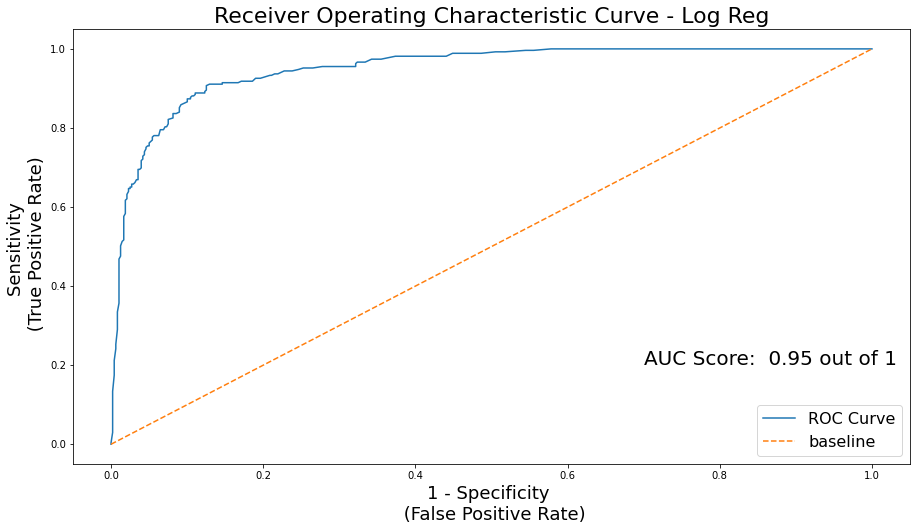

In [86]:
# ROC of y_val
roc(pred_log_reg_tfidf_2_df, 'y_true', 'pred_probs', (15,8), 0.7,0.2, 'Log Reg')

<span style= "color:magenta">Remarks:</span> Looking at the ROC curve, with a AUC socre of 0.95 which is very close to 1. It give me confident that the model is working well against the evaluation data set. The max score of AUC scorce is 1.

#### Confusion Matrix: Log Reg with TF-IDF

In [87]:
# Generate a confusion matrix.
confusion_matrix(y_lem_val,pred_log_reg_tfidf_2)

array([[443,  36],
       [ 50, 219]], dtype=int64)

Accuracy:           0.89
Misclassification:  0.11
Sensitivity:        0.81
Specificity:        0.92
Precision:          0.86
Prevalence:          0.36


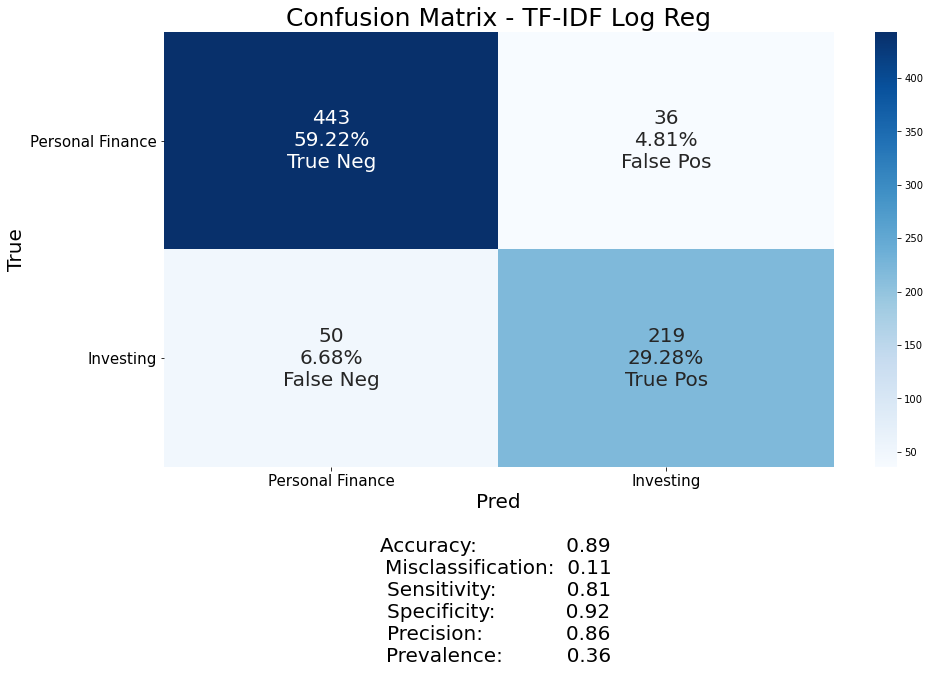

In [88]:
# Print Confusion Matrix Statistic
c_matrix(y_lem_val, pred_log_reg_tfidf_2, (15,8), 'TF-IDF Log Reg')

In [89]:
# Reform X_val and y_val with prediction
df_val = pd.concat([X_lem_val,pred_log_reg_tfidf_2_df], axis=1)

# Add in confusion matrix - filter for those that are Type 1 or Type 2 errors
df_val['c_matrix'] = df_val.apply(lambda row: error_type(row['y_true'], row['pred_y']), axis=1)
mask1 = (df_val['c_matrix'] == 'FP') | (df_val['c_matrix'] == 'FN')
df_val[mask1].shape

(86, 5)

<span style= "color:magenta">Remarks:</span> Looking at the confusion matrix, our model is able to class user's comment quite accuracy @ 89%, this is above our agreed threshold of 80%.  
We do notice there there is about 11% errors in our model (Type I & Type II). Upon Investigation, I realized that most of this errors are resulted from users themselves not able to clearly defined their posts as being personal finance or investing.  
Again, the errors, especially type II, are not an issues to our client, Seeking Alpha, as it may means unexpected customers.

The TF-IDF Vectorizer works better compared to the CountVectorizer in this context. Across all metrics used,both the confusion matri and ROC score, TF-IDF Model has scored higher than Count Vec Model. 

In [90]:
# Save 
df_val.to_csv('datasets/log_reg_tfidf_c_matrix_errors.csv')

## Naive Bayes with CountVectorizer

### Pipeline Creation

In [91]:
# Instantiate our model with best params for count vectorizer

pipe_nb_cv = Pipeline(
[
    ('cvec', CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stop_words)),
    ('nb', MultinomialNB())
]
)

In [92]:
pipe_nb_cv_params = {'cvec__ngram_range': [(1,1),(1,2),(1,3),(1,4)],
                   'cvec__max_df': [0.5,0.6,0.7,0.8],
                   'cvec__min_df': [0.1,0.2,0.3],
                   'cvec__max_features': [1000, 2000,3000,4000,5000]               
}

### GridSearch to find the best params

In [93]:
gs = GridSearchCV(pipe_nb_cv,pipe_nb_cv_params, cv=5)

In [94]:
gs.fit(X_lem_train, y_lem_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['mill',
                                                                    'your',
                                                                    'seeming',
                                                                    'first',
                                                                    'bill',
                                                                    'will',
                                                                    'would',
                                                                    'by',
                                                                    'perhaps',
                                                                    'sometime',
                                                                    'none',
                                                                    'it', 'is',
       

In [95]:
gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 1000,
 'cvec__min_df': 0.1,
 'cvec__ngram_range': (1, 1)}

In [96]:
gs.score(X_lem_train, y_lem_train)

0.8852242744063324

In [97]:
gs.score(X_lem_val, y_lem_val)

0.8676470588235294

### Naive Bayes with Count Vec (Best Params)

In [98]:
pipe_nb_cv_2 = Pipeline(
[
    ('cvec', CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stop_words,
                             ngram_range=(1, 1),
                             max_df=0.5,
                             min_df=0.1,
                             max_features = 1000)),
    ('nb', MultinomialNB())
]
)

In [99]:
# Mean Accuracy
cross_val_score(pipe_nb_cv_2, X_lem_train, y_lem_train, cv=5).mean() 

0.8812684557929478

In [100]:
# Fit our model!

pipe_nb_cv_2.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=0.1,
                                 stop_words=['mill', 'your', 'seeming', 'first',
                                             'bill', 'will', 'would', 'by',
                                             'perhaps', 'sometime', 'none',
                                             'it', 'is', 'ie', 'two', 'five',
                                             'whereby', 'has', 'inc', 'also',
                                             'with', 'up', 'de', 'wherever',
                                             'must', 'found', 'three', 'from',
                                             'others', 'where', ...])),
                ('nb', MultinomialNB())])

In [101]:
# Generate our predictions!
pred_nb_cv_2 = pipe_nb_cv_2.predict(X_lem_val)

In [102]:
# Score our model on the training set.
pipe_nb_cv_2.score(X_lem_train, y_lem_train)

0.8852242744063324

In [103]:
# Score our model on the testing set.
pipe_nb_cv_2.score(X_lem_val, y_lem_val)

0.8676470588235294

<span style= "color:magenta">Remarks:</span> Our model accuracy differs only about 0.02% between training and evaluation dataset.

### Evaluating Naive Bayes with Count Vec

In [104]:
# Find prediction
pred_nb_cv_2 = pipe_nb_cv_2.predict(X_lem_val)

# Find Prediction Probability
pred_nb_cv_2_proba = [i[1] for i in pipe_nb_cv_2.predict_proba(X_lem_val)]

# Create dataframe of y-subset for ROC
pred_nb_cv_2_df = pd.DataFrame({'y_true': y_lem_val,
                            'pred_y': pred_nb_cv_2,
                        'pred_probs':pred_nb_cv_2_proba})

In [105]:
pred_nb_cv_2_df.head()

,y_true,pred_y,pred_probs
671,1,1,5.863681e-01
349,1,1,6.486084e-01
1580,0,0,4.188774e-10
1949,0,0,4.109029e-01
2038,0,0,1.614042e-20


#### ROC: Naive Bayes with Count Vec

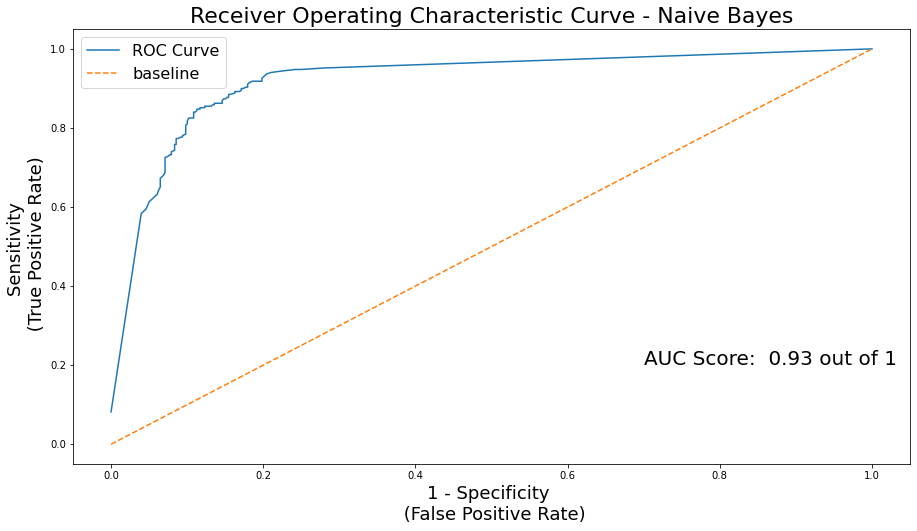

In [106]:
roc(pred_nb_cv_2_df, 'y_true', 'pred_probs', (15,8), 0.7,0.2, 'Naive Bayes')

<span style= "color:magenta">Remarks:</span> Looking at the ROC curve, with a AUC socre of 0.93 which is very close to 1. It give me confident that the model is working well against the evaluation data set. The max score of AUC scorce is 1.

#### Confusion Matrix: Naive Bayes with Count Vec 

In [107]:
# Generate a confusion matrix.
confusion_matrix(y_lem_val,pred_nb_cv_2)

array([[427,  52],
       [ 47, 222]], dtype=int64)

Accuracy:           0.87
Misclassification:  0.13
Sensitivity:        0.83
Specificity:        0.89
Precision:          0.81
Prevalence:          0.36


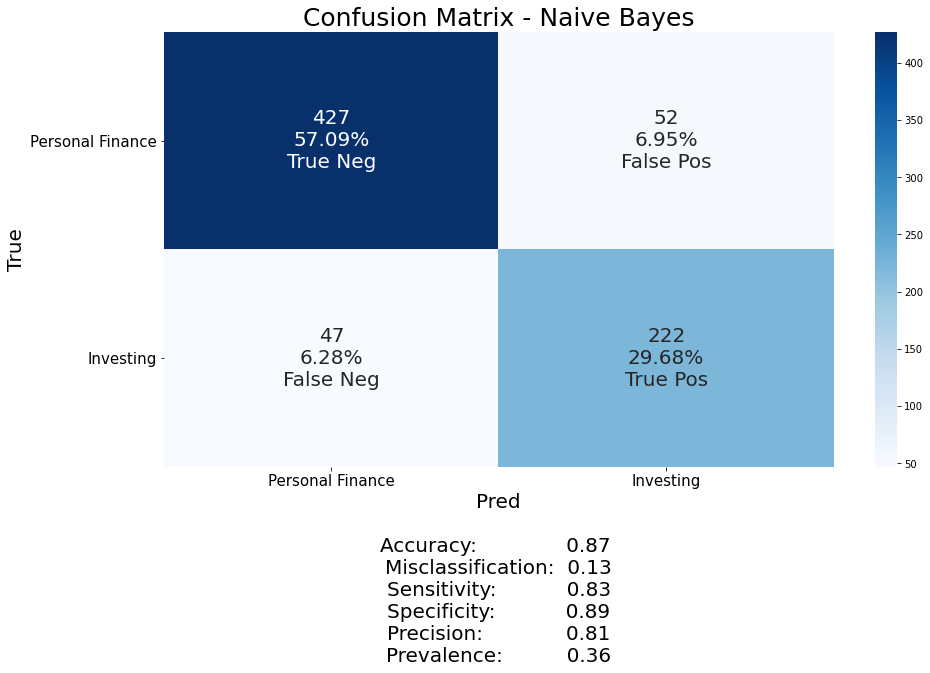

In [108]:
c_matrix(y_lem_val, pred_nb_cv_2, (15,8), 'Naive Bayes')

<span style= "color:magenta">Remarks:</span> Looking at the confusion matrix, our model is able to class user's comment quite accuracy @ 87%, this is above our agreed threshold of 80%. We do notice there there is about 13% errors in our model (Type I & Type II). As mentioned, the errors, especially type II, are not an issues to our client, Seeking Alpha, as it may means unexpected customers.

## Naive Bayes with TF-IDF

### Pipleline Creation

In [109]:
# Instantiate our model with best params for count vectorizer

pipe_nb_tfidf = Pipeline(
[
    ('cvec', TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stop_words)),
    ('nb', MultinomialNB())
]
)

In [110]:
pipe_nb_tfidf_params = {'cvec__ngram_range': [(1,1),(1,2),(1,3),(1,4)],
                   'cvec__max_df': [0.5,0.6,0.7,0.8],
                   'cvec__min_df': [0.1,0.2,0.3],
                   'cvec__max_features': [1000, 2000,3000,4000,5000]               
}

### GridSearch to find the best params

In [111]:
gs = GridSearchCV(pipe_nb_tfidf,pipe_nb_tfidf_params, cv=5)

In [112]:
gs.fit(X_lem_train, y_lem_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words=['mill',
                                                                    'your',
                                                                    'seeming',
                                                                    'first',
                                                                    'bill',
                                                                    'will',
                                                                    'would',
                                                                    'by',
                                                                    'perhaps',
                                                                    'sometime',
                                                                    'none',
                                                                    'it', 'is',
       

In [113]:
gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 1000,
 'cvec__min_df': 0.1,
 'cvec__ngram_range': (1, 1)}

In [114]:
gs.score(X_lem_train, y_lem_train)

0.883245382585752

In [115]:
gs.score(X_lem_val, y_lem_val)

0.8716577540106952

### Naive Bayes with TF-IDF (Best Params)

In [116]:
# Create pipe2 with best params + using custom stopwords
pipe_nb_tfidf_2 = Pipeline(
[
    ('cvec', TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stop_words,
                             ngram_range=(1, 2),
                             max_df=0.5,
                             min_df=0.1,
                             max_features = 1000)),
    ('nb', MultinomialNB())
]
)

In [117]:
# Mean Accuracy
cross_val_score(pipe_nb_tfidf_2, X_lem_train, y_lem_train, cv=5).mean() 

0.8759922702796595

In [118]:
# Fit Model
pipe_nb_tfidf_2.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('cvec',
                 TfidfVectorizer(max_df=0.5, max_features=1000, min_df=0.1,
                                 ngram_range=(1, 2),
                                 stop_words=['mill', 'your', 'seeming', 'first',
                                             'bill', 'will', 'would', 'by',
                                             'perhaps', 'sometime', 'none',
                                             'it', 'is', 'ie', 'two', 'five',
                                             'whereby', 'has', 'inc', 'also',
                                             'with', 'up', 'de', 'wherever',
                                             'must', 'found', 'three', 'from',
                                             'others', 'where', ...])),
                ('nb', MultinomialNB())])

In [119]:
# Train Model accuracy
pipe_nb_tfidf_2.score(X_lem_train, y_lem_train)

0.883245382585752

In [120]:
# Test accuracy
pipe_nb_tfidf_2.score(X_lem_val, y_lem_val)

0.8729946524064172

<span style= "color:magenta">Remarks:</span> Our model accuracy differ by about 0.1% between training and evaluation dataset.

### Evaluating Naive Bayes With TD-IDF

In [121]:
# Find prediction
pred_nb_tfidf_2 = pipe_nb_tfidf_2.predict(X_lem_val)

# Find Prediction Probability
pred_nb_tfidf_2_proba = [i[1] for i in pipe_nb_tfidf_2.predict_proba(X_lem_val)]

# Create dataframe of y-subset for ROC
pred_nb_tfidf_2_df = pd.DataFrame({'y_true': y_lem_val,
                            'pred_y': pred_nb_tfidf_2,
                        'pred_probs':pred_nb_tfidf_2_proba})

In [122]:
pred_nb_tfidf_2_df.head()

,y_true,pred_y,pred_probs
671,1,1,0.521680
349,1,0,0.469805
1580,0,0,0.143358
1949,0,0,0.396386
2038,0,0,0.042673


#### ROC: Naive Bayes with TF-IDF

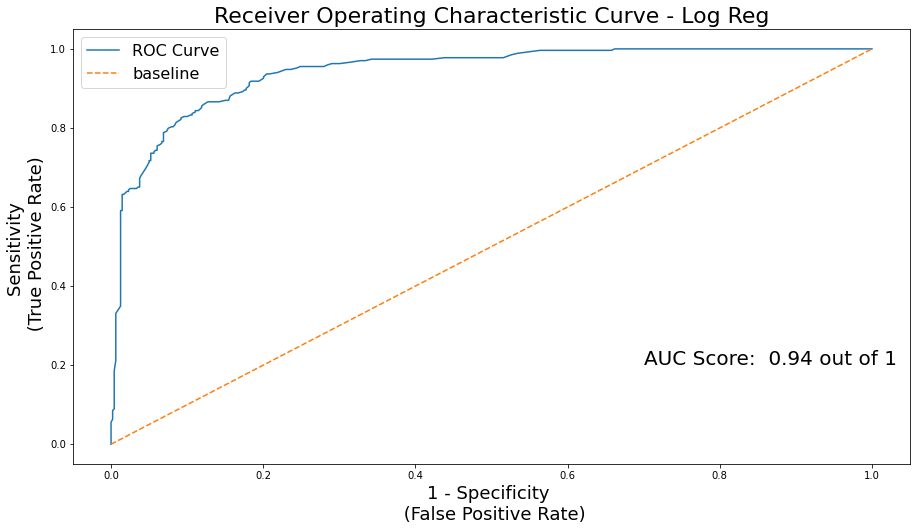

In [123]:
# ROC of y_val
roc(pred_nb_tfidf_2_df, 'y_true', 'pred_probs', (15,8), 0.7,0.2, 'Log Reg')

<span style= "color:magenta">Remarks:</span> Looking at the ROC curve, with a AUC socre of 0.94 which is very close to 1. It give me confident that the model is working well against the evaluation data set. The max score of AUC scorce is 1.

#### Confusion Matrix: Naive Bayes with TD-IDF

In [124]:
# Generate a confusion matrix.
confusion_matrix(y_lem_val,pred_nb_tfidf_2)

array([[446,  33],
       [ 62, 207]], dtype=int64)

Accuracy:           0.87
Misclassification:  0.13
Sensitivity:        0.77
Specificity:        0.93
Precision:          0.86
Prevalence:          0.36


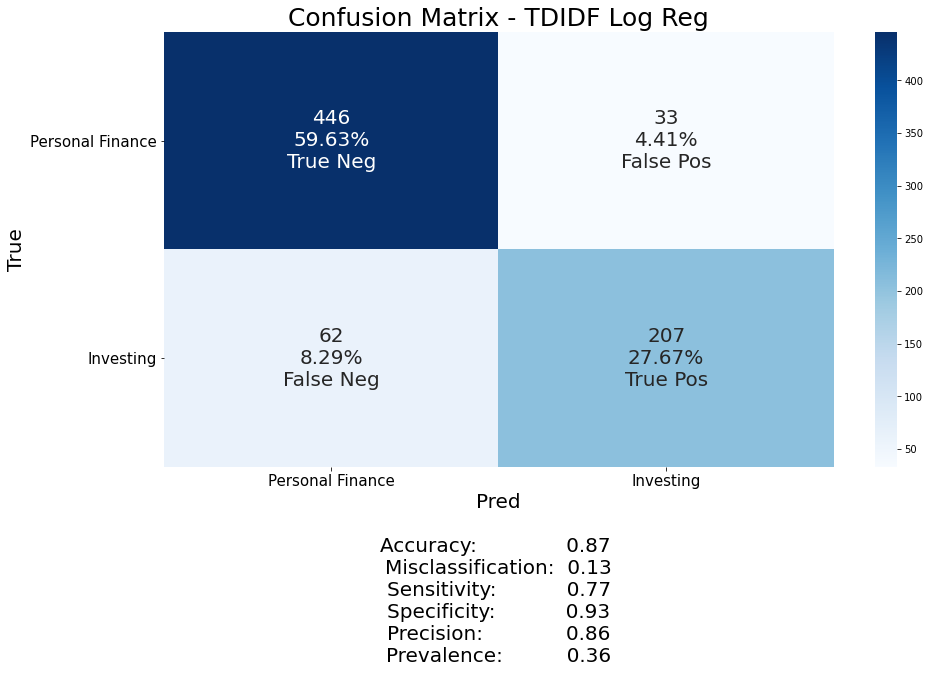

In [125]:
# Print Confusion Matrix Statistic
c_matrix(y_lem_val, pred_nb_tfidf_2, (15,8), 'TDIDF Log Reg')

In [126]:
# Reform X_val and y_val with prediction
df_val = pd.concat([X_lem_val,pred_nb_tfidf_2_df], axis=1)

# Add in confusion matrix - filter for those that are Type 1 or Type 2 errors
df_val['c_matrix'] = df_val.apply(lambda row: error_type(row['y_true'], row['pred_y']), axis=1)
mask1 = (df_val['c_matrix'] == 'FP') | (df_val['c_matrix'] == 'FN')
df_val[mask1].shape

(95, 5)

<span style= "color:magenta">Remarks:</span> Looking at the confusion matrix, our model is able to class user's comment quite accuracy @ 87%, this is above our agreed threshold of 80%. We do notice there there is about 13% errors in our model (Type I & Type II). Per above, the errors, especially type II, are not an issues to our client, Seeking Alpha, as it may means unexpected customers.

In the case of Naive Bayes, The the 2 models performed almost on par with each other.

In [127]:
# Save 
df_val.to_csv('datasets/nb_tfidf_c_matrix_errors.csv')

## Conclusion & Recommendation 

**Metric Evaluation**  

At a high-level evaluation, the 4 models are predicting correctly at least 87-89% of the time. This has exceeded the minimum requirement of the model to be at least 80%. Also, the precision, among what is predicted true, how many are true, are at least 81%; suggesting that all three models work well for the clients. At a deeper level. the three models' sensitivity and specificity are also high on top of the fact that the prevalence rate is low ~ 34. Hence we can confidently say that our models are robust in classifying unseen text (new data) correctly.

**ROC Evaluation**  

The ROC for both models is at least 0.93 out of a max of 1. This also gives a perspective that the model works well in classifying the posts correctly.

**Recommendation**  

Given the business context of the entire project, I would suggest client use the TF-IDF as the text-processing method and Naive Bayes model even though based on the metrics (Confusion Matrix and ROC) Log Regression is better than Naive Bayes. The reasons, although not exhaustive, are as follows:  

Naive Bayes works well even when there are small training data set compared to logistic regression, this can be the case in the financial market where new trading vehicles are created all the time. This will allow clients to still relative accurately identify target users who may be posting about emerging trade ideas (very few posts)    

Naive Bayes is highly scalable and also work well as the number of predictors increase. This also a likely case as the business evolves, other forms of data are available and Naive Bayes can handle such increments well as compared to Logistic Regression.  

TF-IDF is a score that tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power. This has an edge over Count Vectorizer which only rank the importance of a word based on its frequency.  

TF-IDF also works better in the context of financial markets. There are too many products available hence the frequency of a keyword occurring in every post is minimum. As TF-IDF will give more weight to less occurring words, this will allow our client, Seeking Alpha, to pick up upcoming trend (eg. new bitcoins, product) in advance and position their marketing accordingly.

**Consideration**  

Examining the Type I & Type II errors where the models classified wrongly, the errors are generally due to users not able to articulate or word their posts correctly. This is understandable as not all users are a finance professional and due to the similarity of the topic where at times, or increasingly investing are considered a component of personal finance; Further 'cleaning' of model vocabulary might not justify the resource allocated to it given the low number of errors that occurs. One business solutions are to consider users who are classified wrongly as potential customers to market to assuming the chance of converting them into potential clients outweighs their complaints of receiving spams marketing.  

As a value add - Client can consider their marketing efforts on Monday - Thursday from 9 pm to 12 midnight as based on the post frequency; these days and times have the highest.

### Supplementary Charts

Text(0.5, 1.0, 'Number of posts by hours')

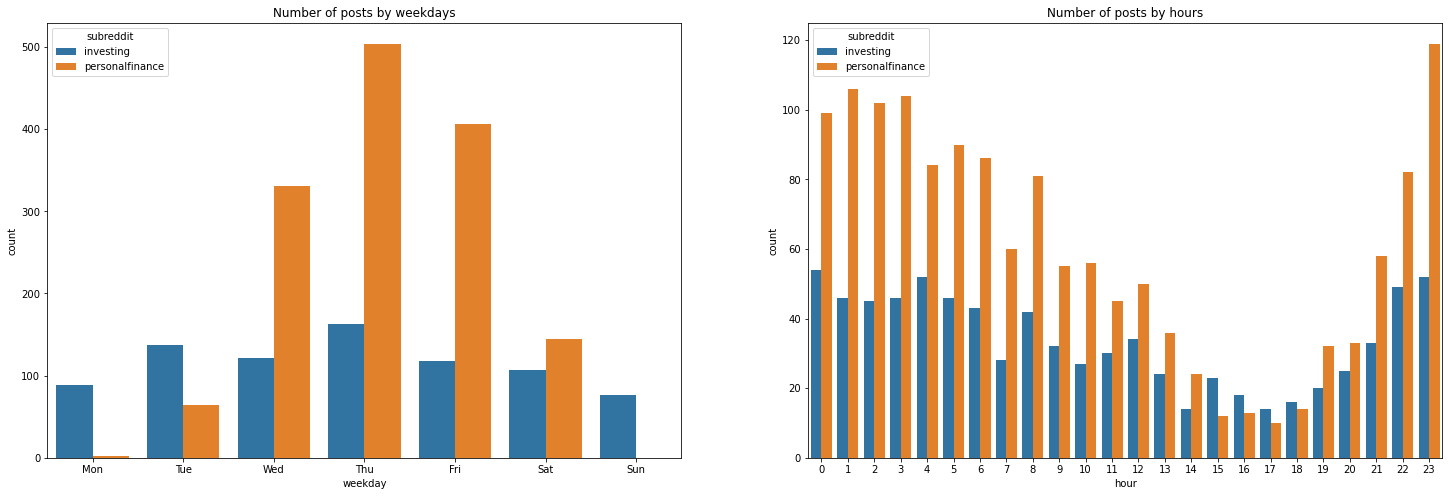

In [128]:
fig, axes = plt.subplots(1,2, figsize=(25,8))
sns.countplot(x='weekday', hue='subreddit', data=df, ax= axes[0])
sns.countplot(x='hour', hue='subreddit', data=df, ax=axes[1])
axes[0].set_title('Number of posts by weekdays')
axes[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu','Fri', 'Sat','Sun'])
axes[1].set_title('Number of posts by hours')